# **ReWOO (Reasoning WithOut Observation)**

ReWOO (Reasoning WithOut Observation) is a novel prompting paradigm designed to enhance the efficiency and accuracy of Augmented Language Models (ALMs) by decoupling reasoning from observation-dependent interactions with external tools. This approach mitigates issues such as high computational cost and token redundancy prevalent in conventional ALM methodologies.

### Key Concepts of ReWOO:
1. **Decoupled Reasoning and Observation**: Unlike traditional ALMs, which require LLMs to halt their reasoning process to fetch external tool responses, ReWOO enables models to generate a structured reasoning plan before interacting with external data sources.
2. **Modular Plan-Work-Solve Framework**:
   - **Planner**: Constructs a comprehensive plan outlining logical steps required to solve the given task.
   - **Worker**: Retrieves the necessary information from external tools based on the Planner’s blueprint.
   - **Solver**: Synthesizes retrieved evidence and plans to generate the final answer.
3. **Token Efficiency**: ReWOO reduces token consumption by eliminating redundant context repetitions, achieving up to 5× token efficiency compared to interleaved reasoning paradigms like ReAct.
4. **Scalability and Specialization**: By decoupling parametric reasoning from non-parametric tool calls, ReWOO allows for instruction fine-tuning, enabling smaller models like LLaMA 7B to approximate the reasoning capabilities of larger models such as GPT-3.5.
5. **Robustness Against Tool Failures**: In scenarios where external tools fail or return incomplete results, ReWOO remains resilient by structuring logical inferences before calling tools, reducing dependency on external observations.

### Advantages of ReWOO:
- **Lower Computational Overhead**: Reduces prompt redundancy, cutting down costs in commercial LLM APIs.
- **Improved Accuracy**: Achieves a 4% improvement in reasoning accuracy on complex tasks like HotpotQA.
- **Enhanced Generalization**: Facilitates the transition of reasoning abilities from large models to smaller, fine-tuned models, making ALMs more accessible and scalable.
- **Better Multi-Step Task Handling**: Suitable for multi-hop reasoning and fact-checking applications that require structured workflows rather than continuous interruptions.

ReWOO marks a significant shift in how LLMs interact with external knowledge, optimizing efficiency and enhancing performance for real-world AI applications.

Paper link: https://arxiv.org/pdf/2305.18323

Code Reference: https://github.com/langchain-ai/langgraph/blob/main/docs/docs/tutorials/rewoo/rewoo.ipynb

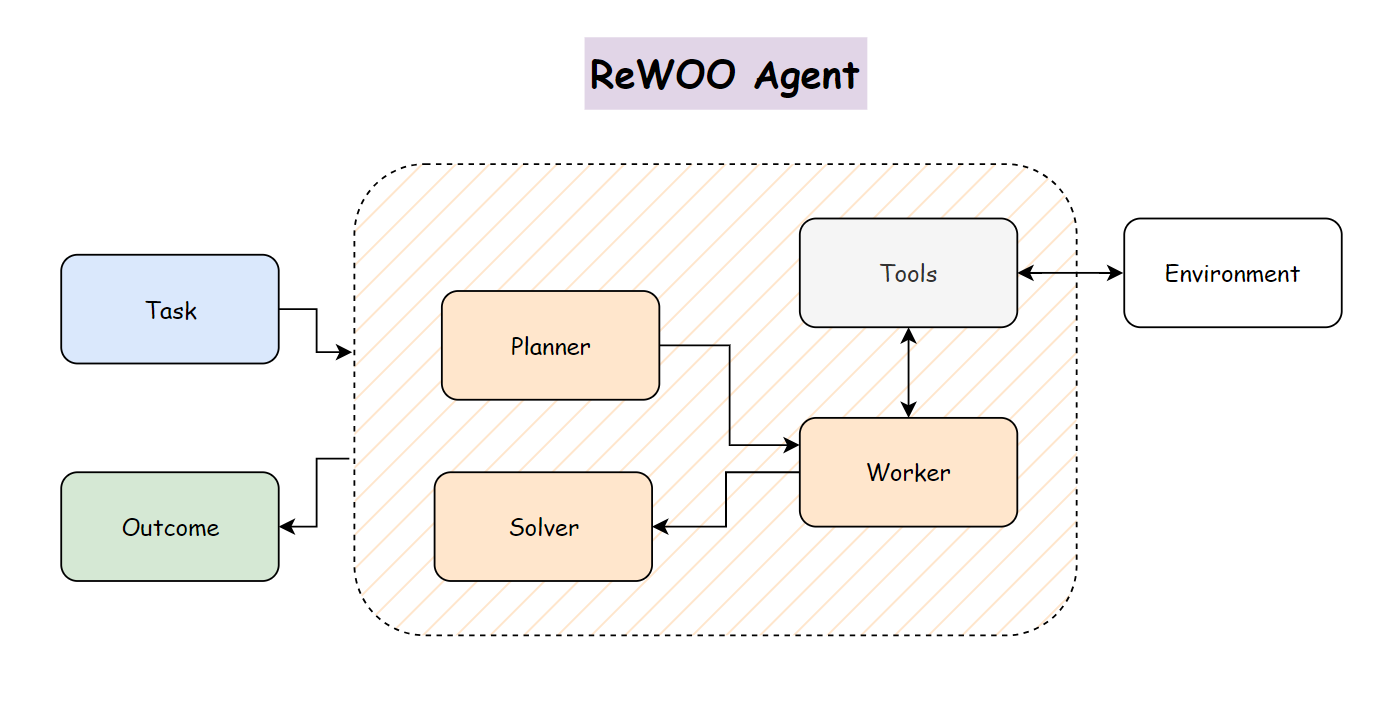

In [ ]:
# install dependencies
!pip install --q langgraph langchain-community langchain_openai

In [ ]:
import os
from google.colab import userdata
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')

In [ ]:
from typing import List
from typing_extensions import TypedDict

class ReWOO(TypedDict):
    task: str
    plan_string: str
    steps: List
    results: dict
    result: str

In [ ]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")

In [ ]:
from langchain_community.tools.tavily_search import TavilySearchResults
search = TavilySearchResults()

In [ ]:
prompt = """For the following task, make plans that can solve the problem step by step. For each plan, indicate \
which external tool together with tool input to retrieve evidence. You can store the evidence into a \
variable #E that can be called by later tools. (Plan, #E1, Plan, #E2, Plan, ...)

Tools can be one of the following:
(1) websearch[input]: Worker that searches results from websearch. Useful when you need to find short
and succinct answers about a specific topic. The input should be a search query.
(2) LLM[input]: A pretrained LLM like yourself. Useful when you need to act with general
world knowledge and common sense. Prioritize it when you are confident in solving the problem
yourself. Input can be any instruction.

For example,
Task: Thomas, Toby, and Rebecca worked a total of 157 hours in one week. Thomas worked x
hours. Toby worked 10 hours less than twice what Thomas worked, and Rebecca worked 8 hours
less than Toby. How many hours did Rebecca work?
Plan: Given Thomas worked x hours, translate the problem into algebraic expressions and solve
with Wolfram Alpha.
#E1 = WolframAlpha[Solve x + (2x − 10) + ((2x − 10) − 8) = 157]
Plan: Find out the number of hours Thomas worked.
#E2 = LLM[What is x, given #E1]
Plan: Calculate the number of hours Rebecca worked.
#E3 = Calculator[(2 ∗ #E2 − 10) − 8]

Begin!
Describe your plans with rich details. Each Plan should be followed by only one #E.

Task: {task}"""

In [ ]:
task = "what is the exact hometown of the 2024 mens australian open winner"

In [ ]:
response = llm.invoke(prompt.format(task=task))

In [ ]:
print(response.content)

Plan: Begin by identifying the winner of the 2024 Men's Australian Open using websearch. This will provide the name of the player who won the tournament.
#E1 = websearch["2024 Men's Australian Open winner"]

Plan: Once we have the winner's name, search for the winner's exact hometown using websearch, as this specific information might not be widely known but potentially available from reliable sources like the player's official profiles or other reputable databases.
#E2 = websearch["hometown of 2024 Men's Australian Open winner #E1"]


In [ ]:
import re
from langchain_core.prompts import ChatPromptTemplate

# Regex to match expressions of the form E#... = ...[...]
regex_pattern = r"Plan\:\s*(.*?)\s*(#E\d+)\s*=\s*(\w+)\[(.*?)\]"
prompt_template = ChatPromptTemplate.from_messages([("user", prompt)])
planner = prompt_template | llm


def get_plan(state: ReWOO):
    task = state["task"]
    result = planner.invoke({"task": task})
    matches = re.findall(regex_pattern, result.content)
    return {"steps": matches, "plan_string": result.content}

In [ ]:
def _get_current_task(state: ReWOO):
    if "results" not in state or state["results"] is None:
        return 1
    if len(state["results"]) == len(state["steps"]):
        return None
    else:
        return len(state["results"]) + 1


def tool_execution(state: ReWOO):
    """Worker node that executes the tools of a given plan."""
    _step = _get_current_task(state)
    _, step_name, tool, tool_input = state["steps"][_step - 1]
    _results = (state["results"] or {}) if "results" in state else {}
    for k, v in _results.items():
        tool_input = tool_input.replace(k, v)
    if tool == "websearch":
        result = search.invoke(tool_input)
    elif tool == "LLM":
        result = llm.invoke(tool_input)
    else:
        raise ValueError
    _results[step_name] = str(result)
    return {"results": _results}

In [ ]:
solve_prompt = """Solve the following task or problem. To solve the problem, we have made step-by-step Plan and \
retrieved corresponding Evidence to each Plan. Use them with caution since long evidence might \
contain irrelevant information.

{plan}

Now solve the question or task according to provided Evidence above. Respond with the answer
directly with no extra words.

Task: {task}
Response:"""


def solve(state: ReWOO):
    plan = ""
    for _plan, step_name, tool, tool_input in state["steps"]:
        _results = (state["results"] or {}) if "results" in state else {}
        for k, v in _results.items():
            tool_input = tool_input.replace(k, v)
            step_name = step_name.replace(k, v)
        plan += f"Plan: {_plan}\n{step_name} = {tool}[{tool_input}]"
    prompt = solve_prompt.format(plan=plan, task=state["task"])
    result = llm.invoke(prompt)
    return {"result": result.content}

In [ ]:
def _route(state):
    _step = _get_current_task(state)
    if _step is None:
        # We have executed all tasks
        return "solve"
    else:
        # We are still executing tasks, loop back to the "tool" node
        return "tool"

In [ ]:
from langgraph.graph import END, StateGraph, START

graph = StateGraph(ReWOO)
graph.add_node("plan", get_plan)
graph.add_node("tool", tool_execution)
graph.add_node("solve", solve)
graph.add_edge("plan", "tool")
graph.add_edge("solve", END)
graph.add_conditional_edges("tool", _route)
graph.add_edge(START, "plan")

app = graph.compile()

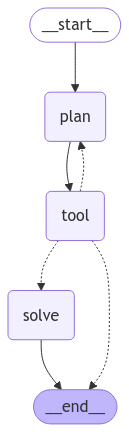

In [ ]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
for s in app.stream({"task": task}):
    print(s)
    print("---")

{'plan': {'steps': [("Search for the winner of the 2024 Men's Australian Open.", '#E1', 'websearch', '"2024 Men\'s Australian Open winner"'), ("Retrieve details about the winner's hometown using the search result from #E1.", '#E2', 'LLM', '"Find the hometown of #E1, the 2024 Men\'s Australian Open winner"')], 'plan_string': 'To solve this task, we need to find out the winner of the 2024 Men\'s Australian Open and then determine their exact hometown. Here\'s how we can approach it step-by-step:\n\nPlan: Search for the winner of the 2024 Men\'s Australian Open.\n#E1 = websearch["2024 Men\'s Australian Open winner"]\n\nPlan: Retrieve details about the winner\'s hometown using the search result from #E1.\n#E2 = LLM["Find the hometown of #E1, the 2024 Men\'s Australian Open winner"]\n\nNow, with these steps, we will be able to identify both the winner\'s name and their exact hometown.'}}
---
{'tool': {'results': {'#E1': '[{\'url\': \'https://vsin.com/wp-content/uploads/2024/01/Circa-Betting

In [ ]:
task1 = 'What is the name of the cognac house that makes the main ingredient in The Hennchata?'

In [ ]:
for s in app.stream({"task": task1}):
    print(s)
    print("---")

{'plan': {'steps': [('Identify the main ingredient in The Hennchata utilizing general awareness about the drink.', '#E1', 'LLM', 'What is the main ingredient in The Hennchata?'), ('Once the main ingredient is identified, find out which cognac house produces this ingredient by using a web search.', '#E2', 'websearch', 'Which cognac house makes #E1?')], 'plan_string': 'To determine the cognac house responsible for making the main ingredient in The Hennchata, I will begin by understanding what the main ingredient in The Hennchata is. From this, I can identify the cognac house.\n\nPlan: Identify the main ingredient in The Hennchata utilizing general awareness about the drink.\n#E1 = LLM[What is the main ingredient in The Hennchata?]\n\nPlan: Once the main ingredient is identified, find out which cognac house produces this ingredient by using a web search.\n#E2 = websearch[Which cognac house makes #E1?]'}}
---
{'tool': {'results': {'#E1': 'content=\'The main ingredients in "The Hennchata" a

In [ ]:
task2 = 'What is captial of UK'

In [ ]:
for s in app.stream({"task": task2}):
    print(s)
    print("---")

{'plan': {'steps': [('To find the capital of the United Kingdom, use general world knowledge to provide a confident answer.', '#E1', 'LLM', 'What is the capital of the United Kingdom?')], 'plan_string': 'Plan: To find the capital of the United Kingdom, use general world knowledge to provide a confident answer.\n#E1 = LLM[What is the capital of the United Kingdom?]'}}
---
{'tool': {'results': {'#E1': "content='The capital of the United Kingdom is London.' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 16, 'total_tokens': 26, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_076d6600c1', 'finish_reason': 'stop', 'logprobs': None} id='run-6cfca7e5-eb02-4478-b251-765dbf7ed925-0' usage_metadata={'input_tokens': 1